# Experiments expanding on Ito et al. (2017)


Set up environment

In [1]:
import copy
import sys
sys.path.append('../utils/')
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.filters.filtertools import recursive_filter

## Import custom modules
# Primary module with most model functions
import model
# Module for FC regression
import multregressionconnectivity as mreg

Helper functions

In [2]:
phi = lambda x: np.tanh(x)

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def scatter_two_vars(a,b):
    d = {'Var1': a, 'Var2': b}
    df = pd.DataFrame(data=d)
    p = sns.regplot(x='Var1', y='Var2', data = df)
    p.text(min(a), max(b), "r = %s"%(str(round(np.corrcoef(a, b)[1][0],3))), horizontalalignment='left', color='black')

## Experiment 1: GLM recovery of simulated task activity


### Create network

One hub and two local networks

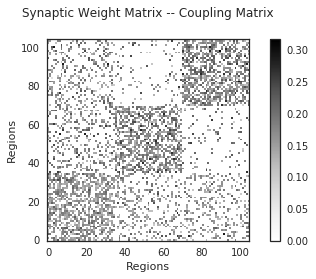

In [3]:
#### Set up subject network matrix ####
# Parameters for subject's networks
ncommunities = 3
innetwork_dsity = .60
outnetwork_dsity = .08
hubnetwork_dsity = .25

nodespercommunity = 35
totalnodes = nodespercommunity*ncommunities

# Construct structural matrix
W = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=False)
# Construct synaptic matrix
G = model.generateSynapticNetwork(W, showplot=True)

#### Simulate resting state activity using information flow model

Apply neural networl]k model **(Eq 3 in paper)** to the connectivity matrix and calculate each nodes' activity for each time point

**Note that this is still in synaptic space (i.e. not convolved)**

In [4]:
## Set up simulation parameters
#Tmaxrest = 60000 # 1min resting state data
Tmaxrest = 300000 # 5min resting state data
dt = 1.0
tau = 1.0
g = 1.0
s = 1.0
TRLength = 100

restdata = model.networkModel(G, 
                              Tmax=Tmaxrest,
                              dt=dt,
                              g=g,
                              s=s,
                              tau=tau,
                              I=None,
                              noise = 1)

In [ ]:
plt.figure()
plt.imshow(restdata, aspect='auto',origin='lower')
plt.title('Simulated resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmaxrest+1,10000),np.arange(0,Tmaxrest+1,10000)/100)
plt.colorbar()

#### Convolve resting state activity

In [ ]:
restfmri = model.convolveTimeseries(restdata,
                                    samplingrate=dt,
                                    TRLength=TRLength)

In [ ]:
plt.figure()
plt.imshow(restfmri, aspect='auto',origin='lower')
plt.title('Simulated fMRI resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

#### Recover connectivity matrix from resting state activity

In [ ]:
fcmat = np.corrcoef(restfmri)
# 0 out the diagonal
np.fill_diagonal(fcmat,0)

plt.figure()
plt.imshow(fcmat, origin='lower')
plt.colorbar()
plt.title('Simulated fMRI resting-state FC \nSingle Subject\nPearsonFC', y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

In [ ]:
fcmat_mreg = mreg.multregressionconnectivity(restfmri)
# 0 out the diagonal
np.fill_diagonal(fcmat_mreg,0)

plt.figure()
plt.imshow(fcmat_mreg, origin='lower')
plt.colorbar()
plt.title('Simulated fMRI resting-state FC\nSingle Subject\nMultipleRegressionFC', y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

How **quantitatively** similar is the fc_mat to the weight matrix G?

In [ ]:
plt.scatter(fcmat.flatten(), G.flatten())
np.corrcoef(fcmat.flatten(), G.flatten())

In [ ]:
plt.scatter(fcmat_mreg.flatten(), G.flatten())
np.corrcoef(fcmat_mreg.flatten(), G.flatten())

### Simulate task activity using resting state

- How do you decide the task's spatial specificity, i.e. which network and nodes within a network it affects primarily? 
    - In the simulations the approach is: For topdown tasks only the hub network is simulated. E.g. for task 1 the first quarter of nodes are stimulated, for task 2 the next quarter etc. 
    - For topdown and bottom up (where a bug was fixed) it is a bit more complicated. E.g. for task 5 the first quarter of the hub network and the nodes of network 1 (first local network) that connect to the hub network (network 0) are stimulated

#### Hub network stimulation

In [5]:
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) # Construct a community affiliation vector
hub_ind = np.where(Ci==0)[0] # Identify the regions associated with the hub network (hub network is by default the 0th network)

# Set number of time points for each task
#Tmax = 10000
Tmax = 300000 #increased to 5 minutes

T = np.arange(0,Tmax,dt)

taskdata = {}
stimtimes = {}
    
# Construct timing array for convolution -- this timing is irrespective of the task being performed
# Tasks are only determined by which nodes are stimulated
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%2000>500 and t%2000<1000:
    #if t>0 and t%1000==0: #Changed to a task with spikes as activity
        tasktiming[0,t] = 1.0

In [6]:
topdown_only = range(1,2)
task = 1

taskcount = task-np.min(topdown_only)
stimsize = np.floor(nodespercommunity/4.0)
stim_nodes = np.arange((taskcount)*stimsize,(taskcount)*stimsize+stimsize,dtype=int)
stimtimes[task] = np.zeros((totalnodes,len(T)))

for t in range(len(T)):
    if tasktiming[0,t] == 1:
        # Task stimulation every 10 seconds for 4 seconds, excluding the first 10 seconds
        # Changed to spike every second for 10 minues
        stimtimes[task][stim_nodes,t] = .5

Block design ~~Spike task~~ looks like:

In [ ]:
plt.plot(T[:10000], tasktiming[0,:10000])
plt.ylim(top = 1.2, bottom = -0.1)

Activated nodes in the hub network *only* (making it a top-down task) are:

In [ ]:
stim_nodes

In [7]:
taskdata[task] = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1)

In [ ]:
plt.figure()
plt.imshow(taskdata[task], aspect='auto',origin='lower')
plt.title('Simulated single topdown task activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmax+1,10000),np.arange(0,Tmax+1,10000)/100)
plt.colorbar()

##### Convolve task activity 


In [ ]:
samplingrate=1.0
# Convolve simulated task data into fMRI signal
task_bold = model.convolveTimeseries(taskdata[task],
                               samplingrate=samplingrate, 
                               TRLength=TRLength)


In [ ]:
plt.figure()
plt.imshow(task_bold, aspect='auto',origin='lower')
plt.title('Simulated single topdown task fMRI activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

##### Run GLM on convolved task activity

In [ ]:
n_skip_BOLD = int(TRLength)
# Temporally downsample task timing to seconds (before convolving)
timingconv = tasktiming[:,::n_skip_BOLD]
timingconv.shape = (timingconv.shape[1],)
hrfsample_rate=1.0 # HRF is sampled at seconds
hrfsample_times = np.arange(0, 30, hrfsample_rate, dtype=float)
hrf_at_simsample = model.hrf(hrfsample_times)
hrfconvtime = np.convolve(timingconv, hrf_at_simsample)
n_to_remove = len(hrf_at_simsample) - 1
convolved = hrfconvtime[:-n_to_remove]
# Output
timing_convolved_downsampled = convolved

In [ ]:
task_betas_postfmri, task_resids_postfmri, task_tvals_postfmri, task_betas_ci_postfmri = model.runTaskGLM(task_bold, timing_convolved_downsampled)

Results of GLM. Vertical lines indicate network boundaries. Stimulated nodes are the first eight in the hub network.

In [ ]:
plt.plot(task_tvals_postfmri)
plt.ylabel('Uncorrected t-value',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=3,linewidth=2, color='red', ls = "--")
plt.axvline(x=35,linewidth=2, color='black', ls = "--")
plt.axvline(x=70,linewidth=2, color='black', ls = "--")

In [ ]:
uperror = task_betas_ci_postfmri[:,1]
downerror = task_betas_ci_postfmri[:,0]
errorbars = np.concatenate(([uperror], [downerror]), axis=0)

plt.errorbar(np.arange(totalnodes), task_betas_postfmri, yerr=errorbars, fmt = 'o')
plt.ylabel('Beta (with 95% CI)',fontsize=14)
plt.xlabel('Node',fontsize=14)

In [ ]:
hub_stim_nodes = stim_nodes

### Relationship between betas and weights from the connectivity matrix

Extract average connectivity between each node and the nodes stimulated by task.  
Correlate these average weights with betas for each node.

NOTE: The weight matrix is *NOT* symmetric (I think) because afferent and efferent connection weights need not be the same.

In [ ]:
check_symmetric(G)

Extract average connectivity of each node with the stim nodes

In [ ]:
afferent_cons = np.empty((0,G.shape[0]), float)
efferent_cons = np.empty((0,G.shape[0]), float)
for i in range(G.shape[0]):
    efferent_cons = np.append(efferent_cons, [G[hub_stim_nodes,i].mean()])
    afferent_cons = np.append(afferent_cons, [G[i,hub_stim_nodes].mean()])

In [ ]:
d = {'Beta': task_betas_postfmri[8:], 'Connectivity': efferent_cons[8:]}
df = pd.DataFrame(data=d)
p = sns.regplot(x='Beta', y='Connectivity', data = df)
p.text(min(task_betas_postfmri[8:]), max(efferent_cons[8:]), "r = %s"%(str(round(np.corrcoef(task_betas_postfmri[8:], efferent_cons[8:])[1][0],3))), horizontalalignment='left', color='black')
p.set_title('Correlation between betas and efferent connections')

In [ ]:
d = {'Beta': task_betas_postfmri[8:], 'Connectivity': afferent_cons[8:]}
df = pd.DataFrame(data=d)
p = sns.regplot(x='Beta', y='Connectivity', data = df)
p.text(min(task_betas_postfmri[8:]), max(afferent_cons[8:]), "r = %s"%(str(round(np.corrcoef(task_betas_postfmri[8:], afferent_cons[8:])[1][0],3))), horizontalalignment='left', color='black')
p.set_title('Correlation between betas and afferent connections')

## Correcting GLM using whole system data

### Uncorrected GLM at neural network level

Using first third of the data for speed of estimation

In [8]:
taskdata_short = copy.copy(taskdata[1][:,:10000])

In [9]:
# Define parameters
ntimepoints = taskdata_short.shape[1]
nregions = taskdata_short.shape[0]

# Define empty variables
task_betas = np.zeros((nregions,))
task_tvals = np.zeros((nregions,))

In [10]:
## Task regressor (I)
X = stimtimes[task][0,:10000].T
## Constant/GLM:
X = sm.add_constant(X)

# Performing a GLM for each region
for region in range(0,nregions):
    
    #Initial GLM regressors:
    
    #DV = Activity in current node
    y = taskdata_short[region,:]
    
    mod = sm.OLS(y, X)
    results = mod.fit()
    
    ## Task regressor outputs
    # Save betas
    task_betas[region]=results.params[1]
    
    # Save t values
    task_tvals[region]=results.tvalues[1]

"Pre" whiten data

In [11]:
taskdata_short_pw = copy.copy(taskdata[1][:,:10000])
ar1 = np.zeros(nregions)
for region in range(nregions):
    mod1 = ARMA(taskdata_short_pw[region,:], order=(1,0))
    res1 = mod1.fit()
    ar1[region] = res1.params[1]
    taskdata_short_pw[region,:] = res1.resid   

In [12]:
# Define empty variables
task_betas_pw = np.zeros((nregions,))
task_tvals_pw = np.zeros((nregions,))

In [13]:
## Task regressor (I)
X = stimtimes[task][0,:10000].T
## Constant/GLM:
X = sm.add_constant(X)

# Performing a GLM for each region
for region in range(0,nregions):
    
    #Initial GLM regressors:
    
    #DV = Activity in current node
    y = taskdata_short_pw[region,:]
    
    mod = sm.OLS(y, X)
    results = mod.fit()
    
    ## Task regressor outputs
    # Save betas
    task_betas_pw[region]=results.params[1]
    
    # Save t values
    task_tvals_pw[region]=results.tvalues[1]

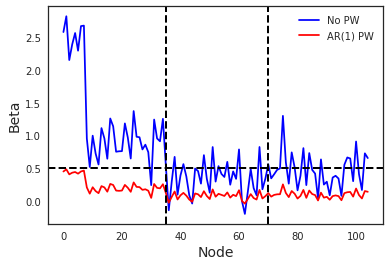

In [14]:
plt.plot(task_betas, color="blue", label="No PW")
plt.plot(task_betas_pw, color="red", label="AR(1) PW")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='black', ls = "--")
plt.axvline(x=35,linewidth=2, color='black', ls = "--")
plt.axvline(x=70,linewidth=2, color='black', ls = "--")
plt.legend(loc="best")

### Corrected GLM at neural network level

In [15]:
# Define empty variables
task_betas_cr = np.zeros((nregions,))
task_tvals_cr = np.zeros((nregions,))
cur_node_betas_cr = np.zeros((nregions,))
other_nodes_betas_cr = np.zeros((nregions,nregions-1))

In [16]:
# Performing a GLM for each region
for region in range(0,nregions):
    
    #print("Running model for region %s"%(str(region)))
    #Initial GLM regressors:
    ## Task regressor (I)
    #X = stimtimes[task][region,:10000].T
    X = stimtimes[task][0,:10000].T
    ## Constant/GLM:
    X = sm.add_constant(X)
    
    #Extending GLM to include:
    ## Activity from current node
    cur_node = taskdata_short[region,:].T
    cur_node = cur_node.reshape(-1,1)
    ## Activity of all other regions (put through the transformation function?)
    drop_region = [region]
    other_nodes = np.delete(taskdata_short, drop_region, axis=0)
    other_nodes = other_nodes.T
    
    X = np.concatenate((X, cur_node), 1)
    X = np.concatenate((X, other_nodes), 1)
    
    #DV = shifted activity in current node
    y = np.r_[0, taskdata_short[region,:-1]].T
    
    #Model before ARMA correction
    mod = sm.OLS(y, X)
    results = mod.fit()
    
    ## Task regressor outputs
    # Save betas
    task_betas_cr[region]=results.params[1]
    
    # Save t values
    task_tvals_cr[region]=results.tvalues[1]
    
    ## Cur node activity
    cur_node_betas_cr[region]=results.params[2]
    
    ##Other nodes activity output
    other_nodes_betas_cr[region:]=results.params[3:]

In [17]:
# Define empty variables
task_betas_cr_pw = np.zeros((nregions,))
task_tvals_cr_pw = np.zeros((nregions,))
cur_node_betas_cr_pw = np.zeros((nregions,))
other_nodes_betas_cr_pw = np.zeros((nregions,nregions-1))

In [18]:
# Performing a GLM for each region
for region in range(0,nregions):
    
    #print("Running model for region %s"%(str(region)))
    #Initial GLM regressors:
    ## Task regressor (I)
    #X = stimtimes[task][region,:10000].T
    X = stimtimes[task][0,:10000].T
    ## Constant/GLM:
    X = sm.add_constant(X)
    
    #Extending GLM to include:
    ## Activity from current node
    cur_node = taskdata_short_pw[region,:].T
    cur_node = cur_node.reshape(-1,1)
    ## Activity of all other regions (put through the transformation function?)
    drop_region = [region]
    other_nodes = np.delete(taskdata_short_pw, drop_region, axis=0)
    other_nodes = other_nodes.T
    
    X = np.concatenate((X, cur_node), 1)
    X = np.concatenate((X, other_nodes), 1)
    
    #DV = shifted activity in current node
    y = np.r_[0, taskdata_short_pw[region,:-1]].T
    
    #Model before ARMA correction
    mod = sm.OLS(y, X)
    results = mod.fit()
    
    ## Task regressor outputs
    # Save betas
    task_betas_cr_pw[region]=results.params[1]
    
    # Save t values
    task_tvals_cr_pw[region]=results.tvalues[1]
    
    ## Cur node activity
    cur_node_betas_cr_pw[region]=results.params[2]
    
    ##Other nodes activity output
    other_nodes_betas_cr_pw[region:]=results.params[3:]

#### Task betas reduced after correction?


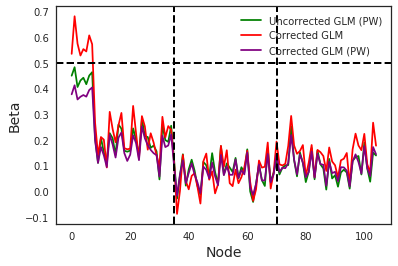

In [19]:
#plt.plot(task_betas, color="blue", label="Uncorrected GLM")
plt.plot(task_betas_pw, color="green", label="Uncorrected GLM (PW)")
plt.plot(task_betas_cr, color="red", label="Corrected GLM")
plt.plot(task_betas_cr_pw, color="purple", label="Corrected GLM (PW)")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='black', ls = "--")
plt.axvline(x=35,linewidth=2, color='black', ls = "--")
plt.axvline(x=70,linewidth=2, color='black', ls = "--")
plt.legend(loc="best")

#### Current node betas == 1?

/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'GLM coefficient for current node activity')

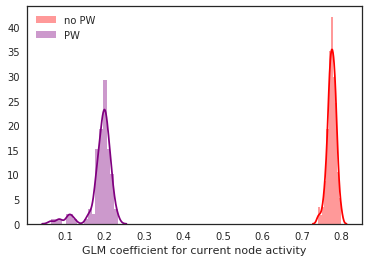

In [20]:
df = pd.DataFrame(data={'no_PW':cur_node_betas_cr,
                       'PW':cur_node_betas_cr_pw})

sns.distplot( df["no_PW"] , color="red", label="no PW")
sns.distplot( df["PW"] , color="purple", label="PW")
sns.plt.legend()
plt.xlabel("GLM coefficient for current node activity")

Relationship between cur betas for non PW data and AR coefs used to PW them

Text(0.7397716055208216, 0.8342340630864352, 'r = -0.345')

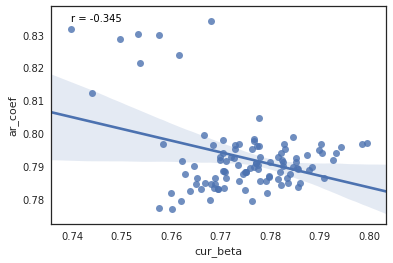

In [21]:
df = pd.DataFrame(data={'cur_beta':cur_node_betas_cr,
                       'ar_coef':ar1})

p = sns.regplot(x='cur_beta', y='ar_coef', data = df)
p.text(min(cur_node_betas_cr), max(ar1), "r = %s"%(str(round(np.corrcoef(cur_node_betas_cr, ar1)[1][0],3))), horizontalalignment='left', color='black')


Taking out the stimulated nodes

Text(0.757594109837308, 0.8046679517601919, 'r = 0.367')

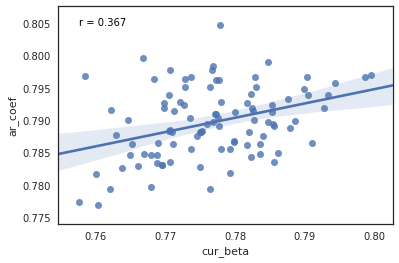

In [22]:
df = pd.DataFrame(data={'cur_beta':cur_node_betas_cr[8:],
                       'ar_coef':ar1[8:]})

p = sns.regplot(x='cur_beta', y='ar_coef', data = df)
p.text(min(cur_node_betas_cr[8:]), max(ar1[8:]), "r = %s"%(str(round(np.corrcoef(cur_node_betas_cr[8:], ar1[8:])[1][0],3))), horizontalalignment='left', color='black')


Including the lagged regressor is basically AR1 pre-whitening. But the coefficient is centered around .77 suggesting that there is room for further improvement in whitening the data.

Trying a moving average (MA) correction.

MA correction isn't as good as AR(1) correction.

In [ ]:
taskdata_short_ma = copy.copy(taskdata[1][:,:10000])
ma1 = np.zeros(nregions)
for region in range(nregions):
    mod1 = ARMA(taskdata_short_ma[region,:], order=(0,1))
    res1 = mod1.fit()
    ma1[region] = res1.params[1]
    taskdata_short_ma[region,:] = res1.resid   

In [ ]:
# Define empty variables
task_betas_cr_ma = np.zeros((nregions,))
task_tvals_cr_ma = np.zeros((nregions,))
cur_node_betas_cr_ma = np.zeros((nregions,))
other_nodes_betas_cr_ma = np.zeros((nregions,nregions-1))

In [ ]:
# Performing a GLM for each region
for region in range(0,nregions):
    
    #print("Running model for region %s"%(str(region)))
    #Initial GLM regressors:
    ## Task regressor (I)
    #X = stimtimes[task][region,:10000].T
    X = stimtimes[task][0,:10000].T
    ## Constant/GLM:
    X = sm.add_constant(X)
    
    #Extending GLM to include:
    ## Activity from current node
    cur_node = taskdata_short_ma[region,:].T
    cur_node = cur_node.reshape(-1,1)
    ## Activity of all other regions (put through the transformation function?)
    drop_region = [region]
    other_nodes = np.delete(taskdata_short_ma, drop_region, axis=0)
    other_nodes = other_nodes.T
    
    X = np.concatenate((X, cur_node), 1)
    X = np.concatenate((X, other_nodes), 1)
    
    #DV = shifted activity in current node
    y = np.r_[0, taskdata_short_ma[region,:-1]].T
    
    #Model before ARMA correction
    mod = sm.OLS(y, X)
    results = mod.fit()
    
    ## Task regressor outputs
    # Save betas
    task_betas_cr_ma[region]=results.params[1]
    
    # Save t values
    task_tvals_cr_ma[region]=results.tvalues[1]
    
    ## Cur node activity
    cur_node_betas_cr_ma[region]=results.params[2]
    
    ##Other nodes activity output
    other_nodes_betas_cr_ma[region:]=results.params[3:]

In [ ]:
#plt.plot(task_betas, color="yellow", label="Uncorrected GLM")
plt.plot(task_betas_pw, color="green", label="Uncorrected GLM (PW)")
plt.plot(task_betas_cr, color="red", label="Corrected GLM")
plt.plot(task_betas_cr_pw, color="purple", label="Corrected GLM (PW)")
plt.plot(task_betas_cr_ma, color="blue", label="Corrected GLM (MA)")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='black', ls = "--")
plt.axvline(x=35,linewidth=2, color='black', ls = "--")
plt.axvline(x=70,linewidth=2, color='black', ls = "--")
plt.legend(loc="best")

#### Other node betas recapitulate connectivity matrix?

**Relationship between other nodes betas and the afferent connectivity weights (can you recover the connectivity matrix?)**

Example relationship between regression coefficients and afferent connectivity weights for one node

In [ ]:
scatter_two_vars(other_nodes_betas_cr[i], np.delete(G[i,:], i))

Distribution of correlations between regression coefficients and connectivity weights for all nodes

In [ ]:
beta_weight_cor = np.zeros(nregions)
beta_weight_cor1 = np.zeros(nregions)
for i in range(nregions):
    beta_weight_cor[i] = np.corrcoef(other_nodes_betas_cr[i], np.delete(G[i,:], i))[1][0]
    beta_weight_cor1[i] = np.corrcoef(other_nodes_betas1_cr[i], np.delete(G[i,:], i))[1][0]
#sns.distplot(beta_weight_cor)
df = pd.DataFrame(data={'no_AR':beta_weight_cor,
                       'AR1':beta_weight_cor1})

sns.distplot( df["no_AR"] , color="skyblue", label="no AR")
sns.distplot( df["AR1"] , color="red", label="AR(1)")
sns.plt.legend()
plt.xlabel("Corr between GLM coefficients \nand connectivity weights")

The relationship between regression coefficients and afferent connectivity weights is not systematically higher for stimulated nodes

In [ ]:
scatter_two_vars(range(nregions), beta_weight_cor)

In [23]:
other_nodes_betas_full = np.zeros((nregions,nregions))
other_nodes_betas_full_pw = np.zeros((nregions,nregions))
for i in range(nregions):
    #add 0's to diagonal
    other_nodes_betas_full[i] = np.insert(other_nodes_betas_cr[i],i,0)
    other_nodes_betas_full_pw[i] = np.insert(other_nodes_betas_cr_pw[i],i,0)

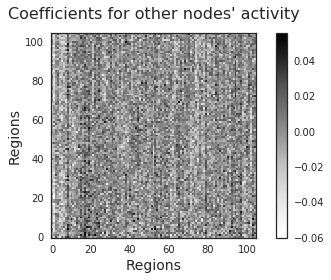

In [24]:
plt.figure()
#plt.imshow(other_nodes_betas1_full, origin='lower')
plt.imshow(other_nodes_betas_full_pw, origin='lower')
plt.colorbar()
plt.title("Coefficients for other nodes' activity", y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

In [25]:
np.corrcoef(other_nodes_betas_full_pw.flatten(), G.flatten())

array([[1.        , 0.16562624],
       [0.16562624, 1.        ]])

(-0.05, 0.35)

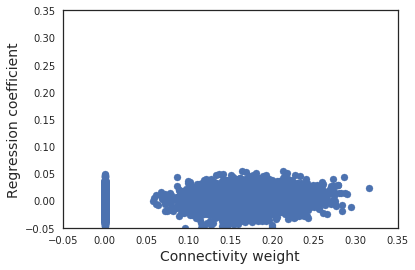

In [26]:
plt.scatter(G.flatten(),other_nodes_betas_full_pw.flatten())
plt.xlabel('Connectivity weight',fontsize=14)
plt.ylabel('Regression coefficient',fontsize=14)
plt.xlim(-0.05, 0.35)
plt.ylim(-0.05, 0.35)

## Turn off AC 

In [27]:
#Turn off autocorrelation
taskdata[2] = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=0,tau=tau,
                                          I=stimtimes[task], noise=1)

### Uncorrected GLM

In [29]:
taskdata_short_noac = copy.copy(taskdata[2][:,:10000])

In [30]:
# Define parameters
ntimepoints = taskdata_short_noac.shape[1]
nregions = taskdata_short_noac.shape[0]

# Define empty variables
task_betas_noac = np.zeros((nregions,))
task_tvals_noac = np.zeros((nregions,))

In [31]:
## Task regressor (I)
X = stimtimes[task][0,:10000].T
## Constant/GLM:
X = sm.add_constant(X)

# Performing a GLM for each region
for region in range(0,nregions):
    
    #Initial GLM regressors:
    
    #DV = Activity in current node
    y = taskdata_short_noac[region,:]
    
    mod = sm.OLS(y, X)
    results = mod.fit()
    
    ## Task regressor outputs
    # Save betas
    task_betas_noac[region]=results.params[1]
    
    # Save t values
    task_tvals_noac[region]=results.tvalues[1]

Prewhitening this data should NOT make a difference in the uncorrected betas

In [34]:
taskdata_short_pw_noac = copy.copy(taskdata[2][:,:10000])
ar1_noac = np.zeros(nregions)
for region in range(nregions):
    mod1 = ARMA(taskdata_short_pw_noac[region,:], order=(1,0))
    res1 = mod1.fit()
    ar1_noac[region] = res1.params[1]
    taskdata_short_pw_noac[region,:] = res1.resid   

/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [36]:
task_betas_pw_noac = np.zeros((nregions,))
task_tvals_pw_noac = np.zeros((nregions,))

# Performing a GLM for each region
for region in range(0,nregions):
    
    #Initial GLM regressors:
    
    #DV = Activity in current node
    y = taskdata_short_pw_noac[region,:]
    
    mod = sm.OLS(y, X)
    results = mod.fit()
    
    ## Task regressor outputs
    # Save betas
    task_betas_pw_noac[region]=results.params[1]
    
    # Save t values
    task_tvals_pw_noac[region]=results.tvalues[1]

Though not as much as it does for data generated with AC PW no AC generated data still improves betas

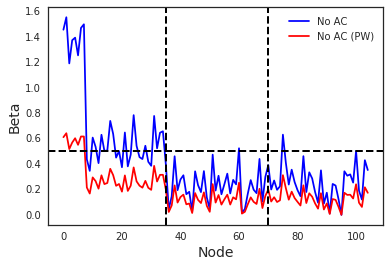

In [42]:
plt.plot(task_betas_noac, color="blue", label="No AC")
plt.plot(task_betas_pw_noac, color="red", label="No AC (PW)")

plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='black', ls = "--")
plt.axvline(x=35,linewidth=2, color='black', ls = "--")
plt.axvline(x=70,linewidth=2, color='black', ls = "--")
plt.legend(loc="best")

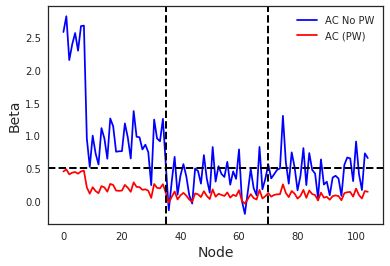

In [43]:
plt.plot(task_betas, color="blue", label="AC No PW")
plt.plot(task_betas_pw, color="red", label="AC (PW)")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='black', ls = "--")
plt.axvline(x=35,linewidth=2, color='black', ls = "--")
plt.axvline(x=70,linewidth=2, color='black', ls = "--")
plt.legend(loc="best")

### Corrected GLM

In [44]:
# Define empty variables
task_betas_cr_noac = np.zeros((nregions,))
task_tvals_cr_noac = np.zeros((nregions,))
cur_node_betas_cr_noac = np.zeros((nregions,))
other_nodes_betas_cr_noac = np.zeros((nregions,nregions-1))

task_betas_cr_pw_noac = np.zeros((nregions,))
task_tvals_cr_pw_noac = np.zeros((nregions,))
cur_node_betas_cr_pw_noac = np.zeros((nregions,))
other_nodes_betas_cr_pw_noac = np.zeros((nregions,nregions-1))

In [45]:
# Performing a GLM for each region
for region in range(0,nregions):
    
    #print("Running model for region %s"%(str(region)))
    #Initial GLM regressors:
    ## Task regressor (I)
    #X = stimtimes[task][region,:10000].T
    X = stimtimes[task][0,:10000].T
    ## Constant/GLM:
    X = sm.add_constant(X)
    
    #Extending GLM to include:
    ## Activity from current node
    cur_node = taskdata_short_noac[region,:].T
    cur_node = cur_node.reshape(-1,1)
    ## Activity of all other regions (put through the transformation function?)
    drop_region = [region]
    other_nodes = np.delete(taskdata_short_noac, drop_region, axis=0)
    other_nodes = other_nodes.T
    
    X = np.concatenate((X, cur_node), 1)
    X = np.concatenate((X, other_nodes), 1)
    
    #DV = shifted activity in current node
    y = np.r_[0, taskdata_short_noac[region,:-1]].T
    
    #Model before ARMA correction
    mod = sm.OLS(y, X)
    results = mod.fit()
    
    ## Task regressor outputs
    # Save betas
    task_betas_cr_noac[region]=results.params[1]
    
    # Save t values
    task_tvals_cr_noac[region]=results.tvalues[1]
    
    ## Cur node activity
    cur_node_betas_cr_noac[region]=results.params[2]
    
    ##Other nodes activity output
    other_nodes_betas_cr_noac[region:]=results.params[3:]
    
    #################################################
    
    X = stimtimes[task][0,:10000].T
    ## Constant/GLM:
    X = sm.add_constant(X)
    
    #Extending GLM to include:
    ## Activity from current node
    cur_node = taskdata_short_pw_noac[region,:].T
    cur_node = cur_node.reshape(-1,1)
    ## Activity of all other regions (put through the transformation function?)
    drop_region = [region]
    other_nodes = np.delete(taskdata_short_pw_noac, drop_region, axis=0)
    other_nodes = other_nodes.T
    
    X = np.concatenate((X, cur_node), 1)
    X = np.concatenate((X, other_nodes), 1)
    
    #DV = shifted activity in current node
    y = np.r_[0, taskdata_short_pw_noac[region,:-1]].T
    
    #Model before ARMA correction
    mod = sm.OLS(y, X)
    results = mod.fit()
    
    ## Task regressor outputs
    # Save betas
    task_betas_cr_pw_noac[region]=results.params[1]
    
    # Save t values
    task_tvals_cr_pw_noac[region]=results.tvalues[1]
    
    ## Cur node activity
    cur_node_betas_cr_pw_noac[region]=results.params[2]
    
    ##Other nodes activity output
    other_nodes_betas_cr_pw_noac[region:]=results.params[3:]
    
    

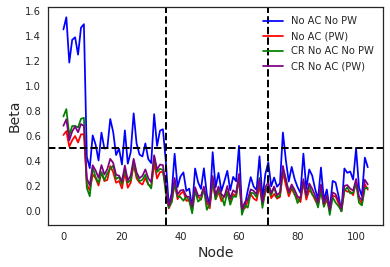

In [47]:
plt.plot(task_betas_noac, color="blue", label="No AC No PW")
plt.plot(task_betas_pw_noac, color="red", label="No AC (PW)")
plt.plot(task_betas_cr_noac, color="green", label="CR No AC No PW")
plt.plot(task_betas_cr_pw_noac, color="purple", label="CR No AC (PW)")

plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='black', ls = "--")
plt.axvline(x=35,linewidth=2, color='black', ls = "--")
plt.axvline(x=70,linewidth=2, color='black', ls = "--")
plt.legend(loc="best")

/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'GLM coefficient for current node activity')

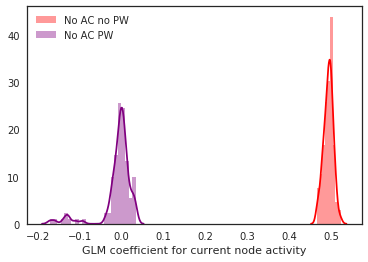

In [48]:
df = pd.DataFrame(data={'no_PW':cur_node_betas_cr_noac,
                       'PW':cur_node_betas_cr_pw_noac})

sns.distplot( df["no_PW"] , color="red", label="No AC no PW")
sns.distplot( df["PW"] , color="purple", label="No AC PW")
sns.plt.legend()
plt.xlabel("GLM coefficient for current node activity")

In [49]:
other_nodes_betas_full_noac = np.zeros((nregions,nregions))
other_nodes_betas_full_pw_noac = np.zeros((nregions,nregions))
for i in range(nregions):
    #add 0's to diagonal
    other_nodes_betas_full_noac[i] = np.insert(other_nodes_betas_cr_noac[i],i,0)
    other_nodes_betas_full_pw_noac[i] = np.insert(other_nodes_betas_cr_pw_noac[i],i,0)

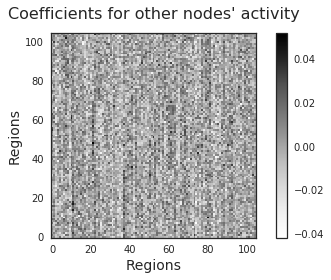

In [50]:
plt.figure()
#plt.imshow(other_nodes_betas1_full, origin='lower')
plt.imshow(other_nodes_betas_full_noac, origin='lower')
plt.colorbar()
plt.title("Coefficients for other nodes' activity", y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

In [53]:
np.corrcoef(other_nodes_betas_full_noac.flatten(), G.flatten())

array([[ 1.        , -0.00336545],
       [-0.00336545,  1.        ]])

(-0.05, 0.35)

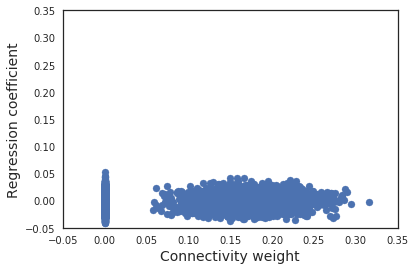

In [54]:
plt.scatter(G.flatten(),other_nodes_betas_full_noac.flatten())
plt.xlabel('Connectivity weight',fontsize=14)
plt.ylabel('Regression coefficient',fontsize=14)
plt.xlim(-0.05, 0.35)
plt.ylim(-0.05, 0.35)